# plant.Watering Logistic Regression

## Problem Statement
We should say should the water pump stay off, turn on for medium (480s) or should it turn full (960s)

## Import all libraries

In [59]:
# Show Plot immedeately
%matplotlib inline 

from scipy import stats
import numpy as np
from matplotlib import pyplot as plt
import pymysql.cursors
import pandas as pd
from datetime import datetime


## Import DataSet

In [60]:
r_DataSet = pd.read_csv("plant.Watering.data/DataSet.csv")

## Variables

Variable | Description
------------- |-------------|
Date          |   29 non-null object
Value         |   Pump Duration (predicted variable)29 non-null float64
Time          |   29 non-null object
DateTime_x    |   29 non-null object
DateTime_y    |   29 non-null object
tre200b0      |   Lufttemperatur 2 m über Boden; Stundenmittel 24h ago °C (tre200b0)
ure200b0      |   Relative Luftfeuchtigkeit 2 m über Boden; Stundenmittel 24h ago % (ure200b0)
rre150b0      |   Niederschlag; Stundensumme 24h ago mm (rre150b0)
sre000b0      |   Sonnenscheindauer; Stundensumme 24h ago min (sre000b0)
fu3010b0      |   Windgeschwindigkeit skalar; Stundenmittel 24h ago km/h (fu3010b0)
prestab0      |   24h-Mean Luftdruck auf Stationshöhe (QFE); Stundenmittel (from -48h to -24h) hPa (prestab0)
tre200b0_mean |   24h-Mean Lufttemperatur 2 m über Boden; Stundenmittel (from -48h to -24h) °C (tre200b0)
ure200b0_mean |  24h-Mean Relative Luftfeuchtigkeit 2 m über Boden; Stundenmittel (from -48h to -24h) % (ure200b0)
rre150b0_sum  |   24h-Summe Niederschlag; Stundensumme (from -48h to -24h) mm (rre150b0)
sre000b0_sum  |  24h-Summe Sonnenscheindauer; Stundensumme (from -48h to -24h) min (sre000b0)
fu3010b0_mean |   24h-Mean Windgeschwindigkeit skalar; Stundenmittel (from -48h to -24h) km/h (fu3010b0)
prestab0_mean |   24h-Mean Luftdruck auf Stationshöhe (QFE); Stundenmittel (from -48h to -24h) hPa (prestab0)

In [61]:
# Print more than one variable
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

r_DataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 14 columns):
Date             94 non-null object
Value            94 non-null float64
tre200b0         94 non-null float64
ure200b0         94 non-null float64
rre150b0         94 non-null float64
sre000b0         94 non-null float64
fu3010b0         94 non-null float64
prestab0         94 non-null float64
tre200b0_mean    94 non-null float64
ure200b0_mean    94 non-null float64
rre150b0_sum     94 non-null float64
sre000b0_sum     94 non-null float64
fu3010b0_mean    94 non-null float64
prestab0_mean    94 non-null float64
dtypes: float64(13), object(1)
memory usage: 10.4+ KB


## Prepare DataSet
- Pump Log longer than 600s. -> Full Throttle
- Pump Log less than 600s, but more than 100s. -> Turn On
- Pump Log less than 100s -> Do not pump!

In [62]:
r_DataSet.insert(0,"Class","",allow_duplicates=False)
r_DataSet.loc[(r_DataSet.Value < 100), "Class"] = 'Off'

r_DataSet.loc[(r_DataSet.Value > 100) & (r_DataSet.Value < 800), "Class"] = 'Med'
r_DataSet.loc[(r_DataSet.Value > 600), "Class"] = 'High'

r_DataSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 15 columns):
Class            94 non-null object
Date             94 non-null object
Value            94 non-null float64
tre200b0         94 non-null float64
ure200b0         94 non-null float64
rre150b0         94 non-null float64
sre000b0         94 non-null float64
fu3010b0         94 non-null float64
prestab0         94 non-null float64
tre200b0_mean    94 non-null float64
ure200b0_mean    94 non-null float64
rre150b0_sum     94 non-null float64
sre000b0_sum     94 non-null float64
fu3010b0_mean    94 non-null float64
prestab0_mean    94 non-null float64
dtypes: float64(13), object(2)
memory usage: 11.1+ KB


## Logistic Regression

### Divide DataSet into TrainingSet (60%) and TestSet (100%) and Define Training Variable (y) and Explanation Variables (X)

In [63]:
p_TrainSet = r_DataSet.sample(frac=0.6, replace=True) #60% of Data
p_TestSet = r_DataSet.sample(frac=1, replace=True) #100% of Data

yTrain = p_TrainSet.Class
yTest = p_TestSet.Class

Xtrain = p_TrainSet.loc[:,"tre200b0":]
# Test Model, get X and y from TestSet
Xtest = p_TestSet.loc[:,"tre200b0":]

### Poly Features

In [64]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn import preprocessing

#polyDegree = 5
#Xtrain = PolynomialFeatures(degree=polyDegree).fit_transform(Xtrain).astype(int)
#Xtest = PolynomialFeatures(degree=polyDegree).fit_transform(Xtest).astype(int)

normalizer = preprocessing.Normalizer().fit(Xtest)  # fit does nothing

Xtrain = normalizer.transform(Xtrain)
Xtest = normalizer.transform(Xtest)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(yTest)

yTrain = le.transform(yTrain)
yTest = le.transform(yTest)

LabelEncoder()

### Train Linear Regression and Set Train Variables

/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

Mean squared error: 0.63
Variance score: 0.61


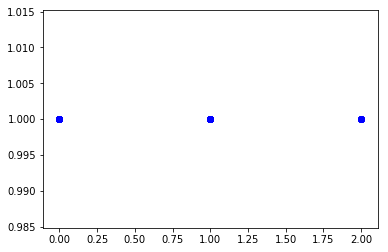

In [69]:
from sklearn.neural_network import MLPClassifier
model = MLPClassifier(# hidden_layer_sizes = (20,40,6 )
                      # , solver = 'sgd'
                      #, learning_rate = 'adaptive'
                      #, alpha = 0.01
#                      , activation = 'logistic'
                     )

model.fit(X = Xtrain, y = yTrain)

# The coefficients
#print('Coefficients: \n', model.coef_)

# The mean squared error
print("Mean squared error: %.2f"
      % np.mean((model.predict(Xtrain) - yTrain) ** 2) ** 0.5)

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model.score(Xtrain, yTrain))

# Plot outputs
plt.scatter(yTrain, model.predict(Xtrain), color='blue')

plt.show()

In [70]:
from sklearn.externals import joblib
#joblib.dump(regr, 'lr_medium_values.pkl', compress=9)

model_clone = model
#model_clone = joblib.load('lr_medium_values.pkl')

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % model_clone.score(Xtest, yTest))


Variance score: 0.64


In [71]:
pd.DataFrame([le.inverse_transform(yTest), le.inverse_transform(model_clone.predict(Xtest))])

,0,1,2,3,4,5,6,7,8,9,...,84,85,86,87,88,89,90,91,92,93
0,Med,Med,Med,Med,Med,Off,High,Off,Off,Med,...,Med,Off,Med,Med,Med,Med,Med,Med,Med,Med
1,Med,Med,Med,Med,Med,Med,Med,Med,Med,Med,...,Med,Med,Med,Med,Med,Med,Med,Med,Med,Med


In [72]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

rowIdx = 85

p_TestSet.iloc[[rowIdx]]
le.inverse_transform(yTest[rowIdx])
le.inverse_transform(model_clone.predict(Xtest)[rowIdx])

,Class,Date,Value,tre200b0,ure200b0,rre150b0,sre000b0,fu3010b0,prestab0,tre200b0_mean,ure200b0_mean,rre150b0_sum,sre000b0_sum,fu3010b0_mean,prestab0_mean
89,Off,2016-09-22,33.003,14.1,82.2,0.0,0.0,14.0,965.0,12.520833,81.8875,5.911938e-14,48.0,4.541667,961.0375


'Off'

'Med'

In [15]:
#Save the model
joblib.dump(model, 'plant.Watering.data/NNClas_5deg.pkl', protocol=2)

['plant.Watering.data/NNClas_5deg.pkl']

#### Port your model to other languages
Very good source for porting pkl (Pickle) Files to other langauges
https://github.com/nok/sklearn-porter

To export the model into JavaScript, run

```bash
python -m sklearn_porter -i NNClas_5deg.pkl -o NNC -l js 
```